In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pymeasure.instruments.srs import SR830



# SR830 Code samples

In [65]:
gpib_addr = '2::9'
# gpib_addr = '0::12'
lockin_pym = SR830(f'GPIB{gpib_addr}::INSTR')
print(lockin_pym.id)
lockin_pym.sample_frequency = 256
lockin_pym.write('FAST0')

Stanford_Research_Systems,SR830,s/n86942,ver1.07


## pyvisa

<AxesSubplot:ylabel='Count'>

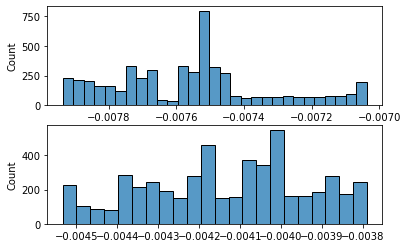

In [50]:
import numpy as np
from pyvisa import ResourceManager
from pyvisa.resources import MessageBasedResource
from time import sleep
class SR830Interface:
    def __init__(self, address):
        # Implement your instrument initialization logic here
        # Example: open a connection to the instrument
        self.rm = ResourceManager()
        self.instrument = self.rm.open_resource(address)

    def buffer_stats(self, time):
        xbuf, ybuf = self.buffer_measure(time =time)
        return [[np.mean(xbuf), np.std(xbuf)], [np.mean(ybuf), np.std(ybuf)]]

    def buffer_measure(self, time):
        self.reset_buffer()
        self.start_buffer()
        sleep(time)
        self.pause_buffer()
        x_bytes, y_bytes =self.read_buffer_bytes()
        x, y = self.buffer_bytes_convert(x_bytes), self.buffer_bytes_convert(y_bytes)
        return x, y


    def buffer_bytes_convert(self, buffer):
        byteproduct = np.array(list(buffer[0::4])) + np.array(list(buffer[1::4]))*2**8
        divsor, remainder = np.divmod(
            byteproduct, 
            32768*np.ones(shape = byteproduct.shape)
        )
        mant = remainder - divsor*2**15
        exp = np.array(list(buffer[2::4]))
        return mant*np.power(np.ones(shape = exp.shape)*2, exp-124)

    def read_buffer_bytes(self):
        buffer_size = self.n_buff()
        self.instrument.write(f'TRCL?1, 0, {buffer_size}')
        x_bytes = self.instrument.read_raw()
        self.instrument.write(f'TRCL?2, 0, {buffer_size}')
        y_bytes = self.instrument.read_raw()

        return [x_bytes, y_bytes]
    
    def read_buffer_ascii(self):
        buffer_size = self.n_buff()
        x_buffer = self.instrument.query_ascii_values(f"TRCA? 1, 0, {buffer_size}")
        y_buffer = self.instrument.query_ascii_values(f"TRCA? 2, 0, {buffer_size}")
        return[x_buffer, y_buffer]

    def start_buffer(self):
        self.instrument.write("STRT")

    def pause_buffer(self):
        self.instrument.write("PAUS")

    def reset_buffer(self):
        self.instrument.write("REST")

    def snap(self):
        return self.instrument.query('SNAP? 1,2')
    
    def n_buff(self):
        return float(self.instrument.query('SPTS?'))
lockin = SR830Interface(f'GPIB{gpib_addr}::INSTR')
xbuf, ybuf =lockin.buffer_measure(10)
fig, ax = plt.subplots(2,1)

sns.histplot(xbuf*1E3, ax = ax[0])
sns.histplot(ybuf*1E3, ax= ax[1])


In [77]:
lockin.start_buffer()
lockin.n_buff()

16383.0

In [64]:
lockin.read_buffer_bytes()

[b'!\xee_\x00!\xee_\x00!\xee_\x00 \xee_\x00 \xee_\x00 \xee_\x00 \xee_\x00\x1f\xee_\x00\x1f\xee_\x00\x1f\xee_\x00\x1f\xee_\x00\x1e\xee_\x00\x1e\xee_\x00\x1e\xee_\x00\x1e\xee_\x00\x1d\xee_\x00\x1d\xee_\x00\x1d\xee_\x00\x1d\xee_\x00\x1c\xee_\x00\x1c\xee_\x00\x1c\xee_\x00\x1c\xee_\x00\x1b\xee_\x00\x1b\xee_\x00\x1b\xee_\x00\x1b\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x1a\xee_\x00\x19\xee_\x00\x19\xee_\x00\x19\xee_\x00\x18\xee_\x00\x18\xee_\x00\x18\xee_\x00\x18\xee_\x00\x17\xee_\x00\x17\xee_\x00\x17\xee_\x00\x17\xee_\x00\x16\xee_\x00\x16\xee_\x00\x16\xee_\x00\x16\xee_\x00\x15\xee_\x00\x15\xee_\x00\x15\xee_\x00\x15\xee_\x00\x14\xee_\x00\x14\xee_\x00\x14\xee_\x00\x14\xee_\x00\x13\xee_\x00\x13\xee_\x00\x13\xee_\x00\x13\xee_\x00\x12\xee_\x00\x12\xee_\x00\x12\xee_\x00\x12\xee_\x00\x11\xee_\x00\x11\xee_\x00\x11\xee_\x00\x11\xee_\x00\x11\xee_\x00\x11\xee_\x00\x11\xee_\x00\x10\xee_\x00\x10\xee_\x00\x10\xee_\x00\x10\xee_\x00\x0f\xee_\x00\x0f

## Parallel measurement

In [17]:
import concurrent.futures 
from multiprocessing import Process

addr_1 = 'GPIB2::9::INSTR'
addr_2 = 'GPIB0::12::INSTR'

lockin_1 = SR830Interface(addr_1)
lockin_2 = SR830Interface(addr_2)

In [78]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    meas_1 = executor.submit(lockin_1.read_buffer_bytes)
    meas_2 = executor.submit(lockin_2.read_buffer_bytes)

    # meas_1 = executor.submit(func1, 4)
    # meas_2 = executor.submit(func2, 2)
    # f1 = executor.submit(func1)
 
    concurrent.futures.wait([meas_1, meas_2])
    print(meas_1.result())
    print(meas_2.result())
    # meas_1.result()
    # meas_2.result()

[b'\xe9\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xea\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xeb\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xec\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xed\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xee\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xef\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_\x00\xf0\r_

In [ ]:
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     meas_1 = executor.submit(lockin_1.buffer_stats(5))
#     meas_2 = executor.submit(lockin_2.buffer_stats(5))

#     # meas_1.result()
#     # meas_2.result()
#     concurrent.futures.wait([meas_1, meas_2])

In [30]:
# p1 = Process(target = lockin_1.buffer_stats, args = [5])
# p1.start()
# p2 = Process(target = lockin_2.buffer_stats, args = [5])


# p2.start()
# p1.join()
# p2.join()

In [24]:
from concurrent.futures import ThreadPoolExecutor

def run_io_tasks_in_parallel(tasks):
    with ThreadPoolExecutor() as executor:
        running_tasks = [executor.submit(task) for task in tasks]
        for running_task in running_tasks:
            running_task.result()

# run_io_tasks_in_parallel([
#     func1
#     lambda: print('IO task 1 running!'),
#     lambda: print('IO task 2 running!'),
# ])

IO task 1 running!
IO task 2 running!


## Pymeasure

In [ ]:
from pymeasure.instruments.srs import SR830

lockin = SR830('GPIB2::25::INSTR')
lockin.binary_values(f'TRCL?1,0, {lockin.buffer_count}')
lockin.values(f'TRCA?1,0, {lockin.buffer_count}', )
lockin.binary_values(f'TRCL?1,0, {lockin.buffer_count}')
xbuffer, ybuffer = lockin.get_buffer_binary(1), lockin.get_buffer_binary(2)
print(xbuffer.mean(), xbuffer.std())
print(ybuffer.mean(), ybuffer.std())
lockin.binary_values(f'TRCB?1,0,{lockin.buffer_count}')

lockin.write('FAST1')
xbuffer = np.array(lockin.get_buffer_float(channel = 1))
ybuffer = np.array(lockin.get_buffer_float(channel = 2))
print(xbuffer.mean(), xbuffer.std())
print(ybuffer.mean(), ybuffer.std())
print(lockin.SAMPLE_FREQUENCIES)
lockin.time_constant = 0.1
lockin.id
lockin.sample_frequency = 16
print(f'lockin sample freq is={lockin.sample_frequency}')
lockin.reset_buffer()
lockin.start_buffer()
lockin.wait_for_buffer(count = 10*lockin.sample_frequency)
print(lockin.buffer_count)
# xbuffer =lockin.get_buffer_binary(1)
# ybuffer= lockin.get_buffer_binary(2)
# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # lockin.read_binary_values()
# bytes =lockin.read_bytes(count =-1)
# np.frombuffer(bytes[0:], dtype = np.float32)

xbuffer = lockin.get_buffer_float(channel = 1)
ybuffer = lockin.get_buffer_float(channel = 2)
fig, [axa, axb] = plt.subplots(2, 1, tight_layout=True)
axa.hist(xbuffer, edgecolor = 'k')
axb.hist(ybuffer, edgecolor = 'k')
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read()
# xbuffer_str = lockin.ask(f'TRCA?1,0,{lockin.buffer_count}',)
# xbuffer_str

# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read_bytes(-1)
# lockin.sample_frequency = 512
# print(f'lockin sample freq is={lockin.sample_frequency}')
# lockin.reset_buffer()
# lockin.start_buffer()
# lockin.wait_for_buffer(count = lockin.sample_frequency*10)
# print(lockin.buffer_count)
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# lockin.read()